In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # 这里使用一个11*11的更大窗口来捕捉对象。
            # 同时，步幅为4，以减少输出的高度和宽度。
            # 另外，输出通道的数目远大于LeNet
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 使用三个连续的卷积层和较小的卷积窗口。
            # 除了最后的卷积层，输出通道的数量进一步增加。
            # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Flatten(),
            # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [3]:
AlexNet().layer_summary((1, 1, 224, 224))

C:\Users\drhu0\miniconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

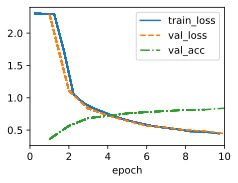

In [4]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import alexnet
from PIL import Image
import requests
from io import BytesIO

# Load the pre-trained AlexNet model
model = alexnet(pretrained=True)
model.eval()

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load image from a URL
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_t = transform(img)
    return img_t

# Example image URL
image_url = 'https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png'
img_tensor = load_image(image_url)

# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)

# Perform inference
with torch.no_grad():
    outputs = model(img_tensor)

# Get the top 5 categories
_, predicted = torch.topk(outputs, 5)
predicted = predicted.squeeze()

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Print predictions
print("Top 5 predicted categories:")
for idx in predicted:
    print(classes[idx])



C:\Users\drhu0\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\drhu0\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\drhu0/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████| 233M/233M [02:21<00:00, 1.73MB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'imagenet_classes.txt'

In [2]:
import requests

# URL to ImageNet class label file
url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'

# Download the file content
response = requests.get(url)
data = response.json()  # This assumes the file is a JSON list of labels

# Write to a text file
with open('imagenet_classes.txt', 'w') as f:
    for label in data:
        f.write(f"{label}\n")

print("ImageNet class labels downloaded and written to 'imagenet_classes.txt'")


ImageNet class labels downloaded and written to 'imagenet_classes.txt'


In [14]:
import torch
import torchvision.transforms as transforms
from torchvision.models import alexnet
from PIL import Image
import requests
from io import BytesIO

# Load the pre-trained AlexNet model
model = alexnet(pretrained=True)
model.eval()

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load image from a URL
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_t = transform(img)
    return img_t

def load_image_(image_path):
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img)
    return img_t
    
# Example image URL
#image_url = 'https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png'
#img_tensor = load_image(image_url)

#image_url = 'download.png'
image_url = 'test3.jpg'
img_tensor = load_image_(image_url)

# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)

# Perform inference
with torch.no_grad():
    outputs = model(img_tensor)

# Get the top 5 categories
_, predicted = torch.topk(outputs, 5)
predicted = predicted.squeeze()

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Print predictions
print("Top 5 predicted categories:")
for idx in predicted:
    print(classes[idx])



Top 5 predicted categories:
pier
dock
boathouse
lakeshore
paddle wheel


In [14]:
#Networks Using Blocks (VGG)
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [35]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            #print('append' ,num_convs,',',out_channels)
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [36]:
myVGG=VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
myVGG.layer_summary((1, 1, 224, 224))
print(myVGG)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
VGG(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kerne

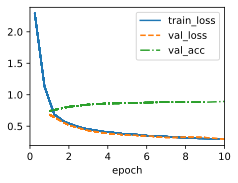

In [37]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
model.layer_summary((1, 1, 224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [40]:
#Network in Network (NiN)
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

In [42]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

In [43]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [44]:
print(NiN())

NiN(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 384, kernel

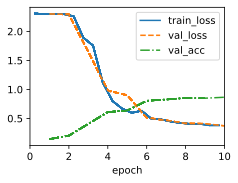

In [45]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [1]:
#Multi-Branch Networks (GoogLeNet)
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [5]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [13]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [11]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [16]:
model = GoogleNet().layer_summary((1, 1, 96, 96))
print(GoogleNet())

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
GoogleNet(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=

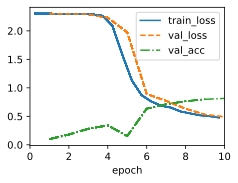

In [15]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

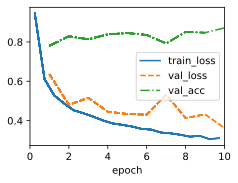

In [2]:
#Batch Normalization
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), 
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), 
            nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), 
            nn.Sigmoid(), 
            nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), 
            nn.Sigmoid(),
            nn.LazyLinear(num_classes))

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [3]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([2.0898, 1.9512, 1.3561, 1.5599, 2.1918, 1.6599],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.1989,  1.0054, -1.0450,  0.7939, -1.3310,  1.3705],
        grad_fn=<ReshapeAliasBackward0>))

In [7]:
model.net[5].gamma.reshape((-1,)), model.net[5].beta.reshape((-1,))

(tensor([1.1740, 1.3186, 1.2694, 1.0809, 1.5800, 1.2520, 1.5270, 1.4792, 1.2084,
         1.3402, 1.3930, 1.2685, 1.5817, 1.1942, 1.3345, 1.3417],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.0082, -0.1290, -0.3962, -0.2635,  0.1618, -0.2120, -0.1442,  0.0292,
         -0.3570,  0.0746, -0.1468,  0.1763,  0.0820,  0.3136, -0.0341,  0.3194],
        grad_fn=<ReshapeAliasBackward0>))

In [8]:
print(model)

BNLeNetScratch(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm()
    (2): Sigmoid()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm()
    (6): Sigmoid()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=120, bias=True)
    (10): BatchNorm()
    (11): Sigmoid()
    (12): Linear(in_features=120, out_features=84, bias=True)
    (13): BatchNorm()
    (14): Sigmoid()
    (15): Linear(in_features=84, out_features=10, bias=True)
  )
)


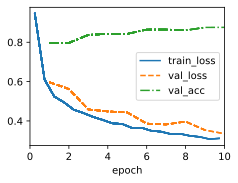

In [3]:
#Concise Implementation of BatchNorm 
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

import multiprocessing as mp

# Set the start method to 'spawn'
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)

    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=128)
    model = BNLeNet(lr=0.1)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model, data)

In [17]:
#Residual Networks (ResNet) and ResNeXt
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [18]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [23]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [24]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [25]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [26]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


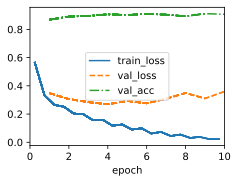

In [27]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [32]:
print(ResNet18())

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import SGD
import torchvision

# Define the ResNeXt Block
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=32):
        super(ResNeXtBlock, self).__init__()
        # Bottleneck width multiplier
        bottleneck_width = 4
        D = out_channels // bottleneck_width
        self.conv1 = nn.Conv2d(in_channels, D, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(D)
        self.conv2 = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=groups)
        self.bn2 = nn.BatchNorm2d(D)
        self.conv3 = nn.Conv2d(D, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return F.relu(out)
        
# Define the ResNeXt Model
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNeXt, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(256, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(512, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(1024, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(2048, num_blocks[3], stride=2)
        self.fc = nn.Linear(2048, num_classes)  # Adjusted the input features to match the output of the last layer

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResNeXtBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Training settings
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = ResNeXt([3, 4, 6, 3], num_classes=10)  # This includes three blocks in the fourth layer
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):  # loop over the dataset multiple times
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}")

print('Finished Training')


Epoch 1, Batch 0, Loss: 2.4635181427001953
Epoch 1, Batch 100, Loss: 0.6210705637931824


In [2]:
#Densely Connected Networks (DenseNet)
import torch
from torch import nn
from d2l import torch as d2l
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), 
        nn.ReLU(), 
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [5]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4), lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

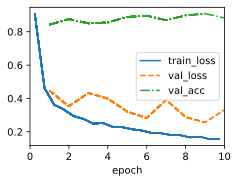

In [7]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [8]:
print(model)

DenseNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (dense_blk1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
       

In [32]:
#https://arxiv.org/abs/1506.01497
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import torchvision.models.detection as models
import numpy as np  # Correctly import numpy
import torch

# Load an image
image_path = './data/bird.jpg'
image_path = 'test1.jpg'
image_path = 'your_image1.jpg'
img = Image.open(image_path)

# Transform and prepare the image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Load a pre-trained Faster R-CNN model
model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Perform inference
with torch.no_grad():
    predictions = model(img_tensor)

# Print predictions
print(predictions)

# Draw bounding boxes and labels on the image
draw = ImageDraw.Draw(img)
for element in range(len(predictions[0]['boxes'])):
    boxes = predictions[0]['boxes'][element].cpu().numpy()
    print(boxes)
    score = np.round(predictions[0]['scores'][element].cpu().numpy(), decimals=4)
    print(score)
    if (score < 0.2):
        continue
    label = predictions[0]['labels'][element].cpu().numpy()
    draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline ="red", width=3)
    draw.text((boxes[0], boxes[1]), f'{label} {score}', fill=(255, 255, 255))

img.show()


[{'boxes': tensor([[1392.7371,  500.9551, 1472.0244,  695.5786],
        [  76.5372,  340.5504, 1631.2695, 1030.6399],
        [1214.4446,  446.1937, 1729.1061,  705.5887],
        [1239.6062,  467.2431, 1381.3727,  544.0758],
        [   0.0000,   31.4281, 1863.0474,  945.1695],
        [1222.9340,  441.0907, 1729.3190,  706.0833],
        [1265.1993,  509.3335, 1392.8832,  688.5550],
        [1233.2640,  476.3271, 1422.9202,  688.4254],
        [  68.7966,  351.7944,  735.7495,  953.0954],
        [   0.0000,   78.7408, 1845.3798, 1040.8778]]), 'labels': tensor([ 1, 65, 22, 28, 72, 19,  1, 22, 65, 33]), 'scores': tensor([0.9959, 0.5874, 0.1490, 0.1413, 0.1361, 0.1307, 0.0876, 0.0831, 0.0753,
        0.0631])}]
[1392.737    500.95508 1472.0244   695.5786 ]
0.9959
[  76.53724  340.55038 1631.2695  1030.6399 ]
0.5874
[1214.4446   446.1937  1729.1061   705.58875]
0.149
[1239.6062  467.2431 1381.3727  544.0758]
0.1413
[   0.        31.42813 1863.0474   945.1695 ]
0.1361
[1222.934    441.0

In [33]:
import cv2
import torch
import torchvision.transforms as T
import torchvision.models.detection as models
import numpy as np

# Load the pre-trained model
model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to process and get model predictions
def get_prediction(frame):
    transform = T.Compose([T.ToTensor()])
    frame = transform(frame).unsqueeze(0)
    with torch.no_grad():
        prediction = model(frame)
    return prediction

# Open the video
cap = cv2.VideoCapture('test.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# Process video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get predictions
    predictions = get_prediction(frame)

    # Draw bounding boxes on the frame
    for element in range(len(predictions[0]['boxes'])):
        boxes = predictions[0]['boxes'][element].cpu().numpy()
        score = predictions[0]['scores'][element].cpu().numpy()
        if score > 0.8:  # Threshold can be adjusted
            x1, y1, x2, y2 = boxes
            frame = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # Write the frame with bounding boxes
    out.write(frame)

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()


In [43]:
import cv2
import torch
import torchvision.transforms as T
import torchvision.models.detection as models
import numpy as np
import time

# Load the pre-trained model
model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to process and get model predictions
def get_prediction(frame):
    transform = T.Compose([T.ToTensor()])
    frame_tensor = transform(frame).unsqueeze(0)
    with torch.no_grad():
        prediction = model(frame_tensor)
    return prediction

# Open the video
cap = cv2.VideoCapture('RilfeShootingTask.mp4')

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_time = total_frames / fps

print(f"Total Frames: {total_frames}")
print(f"Frame Size: {frame_width}x{frame_height} (width x height)")
print(f"Frames Per Second: {fps}")
print(f"Total Time Length: {total_time:.2f} seconds")

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

frame_count = 0

# Process video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Increment frame count
    frame_count += 1
    if frame_count % 100 != 0:
        continue
    print(f"Processing frame {frame_count}")
    
    # Measure processing time
    start_time = time.time()

    # Resize frame to half its size
    frame = cv2.resize(frame, (int(frame.shape[1] / 2), int(frame.shape[0] / 2)))

    # Get predictions
    predictions = get_prediction(frame)

    # Draw bounding boxes on the frame
    for element in range(len(predictions[0]['boxes'])):
        boxes = predictions[0]['boxes'][element].cpu().numpy()
        score = predictions[0]['scores'][element].cpu().numpy()
        if score > 0.5:  # Adjust threshold as needed
            x1, y1, x2, y2 = boxes
            frame = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f"{predictions[0]['labels'][element]}: {score:.2f}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show frame processing time
    elapsed_time = time.time() - start_time
    print(f"Frame {frame_count} processed in {elapsed_time:.2f} seconds")

    # Display the resulting frame
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Write the frame with bounding boxes
    out.write(frame)

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()


Total Frames: 4197
Frame Size: 1920x1080 (width x height)
Frames Per Second: 100.0
Total Time Length: 41.97 seconds
Processing frame 100
Frame 100 processed in 4.34 seconds
Processing frame 200
Frame 200 processed in 4.00 seconds
Processing frame 300
Frame 300 processed in 3.98 seconds
Processing frame 400
Frame 400 processed in 3.99 seconds
Processing frame 500
Frame 500 processed in 4.10 seconds
Processing frame 600
Frame 600 processed in 4.04 seconds
Processing frame 700
Frame 700 processed in 4.19 seconds
Processing frame 800
Frame 800 processed in 4.03 seconds
Processing frame 900
Frame 900 processed in 4.07 seconds
Processing frame 1000
Frame 1000 processed in 4.11 seconds
Processing frame 1100
Frame 1100 processed in 4.11 seconds
Processing frame 1200
Frame 1200 processed in 4.32 seconds
Processing frame 1300
Frame 1300 processed in 4.68 seconds
Processing frame 1400
Frame 1400 processed in 4.46 seconds
Processing frame 1500
Frame 1500 processed in 4.55 seconds
Processing frame 

In [ ]:
import cv2
import torch
import torchvision.transforms as T
import torchvision.models.detection as models
import numpy as np

# Setup
model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
transform = T.Compose([T.ToTensor()])

# Video setup
cap = cv2.VideoCapture('RilfeShootingTask.mp4')
batch_size = 1
frames = []
batch_tensors = []

# Process video
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_tensor = transform(frame).unsqueeze(0)  # Add batch dimension
    frames.append(frame)
    batch_tensors.append(frame_tensor)
    
    # Check if the batch is ready
    if len(batch_tensors) == batch_size:
        batch_tensor = torch.cat(batch_tensors, dim=0)
        with torch.no_grad():
            predictions = model(batch_tensor)
        
        # Draw bounding boxes and show frames
        for i, pred in enumerate(predictions):
            boxes = pred['boxes']
            scores = pred['scores']
            for j, box in enumerate(boxes):
                if scores[j] > 0.5:  # Threshold can be adjusted
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(frames[i], (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.imshow('Frame', frames[i])
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        frames = []
        batch_tensors = []

# Process any remaining frames
if batch_tensors:
    batch_tensor = torch.cat(batch_tensors, dim=0)
    with torch.no_grad():
        predictions = model(batch_tensor)
    
    # Draw bounding boxes and show frames
    for i, pred in enumerate(predictions):
        boxes = pred['boxes']
        scores = pred['scores']
        for j, box in enumerate(boxes):
            if scores[j] > 0.5:  # Threshold can be adjusted
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frames[i], (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow('Frame', frames[i])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Close resources
cap.release()
cv2.destroyAllWindows()
